# Process Stations

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
import pickle

from climpyrical.gridding import transform_coords, find_element_wise_nearest_pos, scale_model_obs
from scipy.interpolate import NearestNDInterpolator

### Load station data for processing

TJan2.5
TJan1.0
TJul97.5
TwJul97.5
HDD
Tmax
Tmin
R15m10
R1d50
PAnn
RAnn
MI
SL50
RL50
WP10
WP50
DRWP5
RHann

In [2]:
# station_dv = 'RL50 (kPa)'
# station_dv = 'mean RH (%)'
# station_dv = 'HDD (degC-day)'
# station_dv = 'SL50 (kPa)'
# station_dv = 'TJan2.5 (degC)'
# station_dv = 'TJan1.0 (degC)'
# station_dv = 'Q10_Gumbel-MM'
# station_dv = 'Q50_Gumbel-MM'
# station_dv = 'Tmin (degC)'
# station_dv = 'Tmax (degC)'
# station_dv = 'TJul2.5 (degC)'
# station_dv = 'TwJul2.5 (degC)'

with open('station_dv.pickle', 'rb') as outfile:
    station_dv = pickle.load(outfile)
    print("Pickled station dv: ", station_dv)

paths = {
    'RL50 (kPa)': 'nrc_data/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv',
    'mean RH (%)': 'nrc_data/rh_annual_mean_10yr_for_maps.csv',
    'HDD (degC-day)': 'nrc_data/Interim_hdd_Tmax_Tmin_delivered.csv',
    'SL50 (kPa)': 'nrc_data/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv',
    'Q10_Gumbel-MM': 'nrc_data/wpress_stations_rl10_rl50.csv',
    'Q50_Gumbel-MM': 'nrc_data/wpress_stations_rl10_rl50.csv',
    'TJan2.5 (degC)': 'nrc_data/janT2.5p_T1.0p_allstations_v3_min8yr_for_maps.csv',
    'TJan1.0 (degC)': 'nrc_data/janT2.5p_T1.0p_allstations_v3_min8yr_for_maps.csv',
    'Tmin (degC)': 'nrc_data/Interim_hdd_Tmax_Tmin_delivered.csv',
    'Tmax (degC)': 'nrc_data/Interim_hdd_Tmax_Tmin_delivered.csv',
    'TJul2.5 (degC)': 'nrc_data/julT97.5p_allstations_v3_min8yr_for_maps.csv',
    'TwJul2.5 (degC)': 'nrc_data/julTwb97.5p_allstations_v3_for_maps.csv',
    'DRWP-RL5 (Pa)': 'nrc_data/drwp_rl5_for_maps.csv',
    'annual_pr (mm)': 'nrc_data/pr_annual_mean_doy_MSC_25yr_for_maps.csv',
    'annual_rain (mm)': 'nrc_data/rain_annual_mean_doy_MSC_25yr_for_maps.csv',
    'RL50 (mm)':'nrc_data/1day_rain_rl50_for_maps.csv'
    
}

filenames = {
    'RL50 (kPa)': 'RL50',
    'mean RH (%)': 'RHann',
    'HDD (degC-day)': 'HDD',
    'SL50 (kPa)': 'SL50',
    'Q10_Gumbel-MM': 'WP10',
    'Q50_Gumbel-MM': 'WP50',
    'TJan2.5 (degC)': 'TJan2.5',
    'TJan1.0 (degC)': 'TJan1.0',
    'Tmin (degC)': 'Tmin',
    'Tmax (degC)': 'Tmax',
    'TJul2.5 (degC)': 'TJul97.5',
    'TwJul2.5 (degC)': 'TwJul97.5',
    'DRWP-RL5 (Pa)': 'DRWP5',
    'annual_pr (mm)': 'PAnn',
    'annual_rain (mm)': 'RAnn',
    'RL50 (mm)': 'R1d50'
}

file_dv = filenames[station_dv]

DF_PATH = resource_filename(
    'climpyrical',
    paths[station_dv]
)

df = pd.read_csv(DF_PATH, index_col=None).dropna()
print(df.columns)

def check_df_columns(df):
    if 'longitude' in df.columns:
        df=df.rename(columns={'longitude': 'lon'})
    if 'long' in df.columns:
        df=df.rename(columns={'long': 'lon'})
    if 'latitude' in df.columns:
        df=df.rename(columns={'latitude': 'lat'})
    if 'name' in df.columns:
        df=df.rename(columns={'name': 'station_name'})
    if 'Name' in df.columns:
        df=df.rename(columns={'Name': 'station_name'})
    return df

df = check_df_columns(df)
    
# transform into rotated pole and assign as new columns
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)

df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)


# Create array of mean
if 'degC' in station_dv and not 'degC-day' in station_dv:
    print("Added!")
    df[station_dv] = df[station_dv].values + 273.15
else:
    print("Not added!")
    df[station_dv] = df[station_dv].values

if 'RL50' in station_dv:
    df = df[df[station_dv] != 0.0]
    print("RL50 Not inluding RL50 == 0")
    assert not np.any(np.isclose(df[station_dv].values, 0.0))

Pickled station dv:  Tmin (degC)
Index(['history_id', 'station_name', 'province', 'lon', 'lat', 'elevation (m)',
       'Tmean', 'Tmin (degC)', 'Tmax (degC)', 'HDD (degC-day)'],
      dtype='object')
Added!


/home/nannau/tri/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Open the pre-processed model

In [3]:
pre_processed_path = resource_filename(
    "climpyrical", 
    f"/nrc_data/processed/{file_dv}_pre_processed.nc"
)

ds = xr.open_dataset(pre_processed_path)
dv = list(ds.data_vars)[0]

### Match stations to grids in model
Find the nearest grid cells to the station locations

In [4]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values,
            df.rlon.values, 
            df.rlat.values
)

matched_df = pd.DataFrame(
    {
        'ilocy': iy, 
        'ilocx': ix, 
        station_dv: df[station_dv], 
        'rlat':df.rlat, 
        'rlon':df.rlon, 
        'lat': df.lat, 
        'lon':df.lon, 
        'station_name':df.station_name
    }
)

matched_df = matched_df.groupby(
    ['ilocy', 'ilocx'], as_index=False
).agg(
    {
        station_dv: 'mean', 
        'rlat':'mean', 
        'rlon':'mean', 
        'lat': 'mean', 
        'lon': 'mean', 
        'station_name': 'first'
    }
)

iy = matched_df.ilocy.values
ix = matched_df.ilocx.values
station_vals = matched_df[station_dv].values

Identify locations where the closest grid cell falls on a invalid model value

In [5]:
nan_index = np.isnan(ds[dv].values[iy, ix])
ixnan, iynan = matched_df.ilocx.values[nan_index], matched_df.ilocy.values[nan_index]
ixnan, iynan

(array([1061, 1250, 1253,  364,  363,  386, 1250,  386,  375,  349, 1393,
         338, 1376,  336,  347,  348, 1403, 1326,  349,  345, 1398, 1365,
         332,  337,  310,  904,  549]),
 array([ 599,  693,  696,  756,  758,  760,  760,  766,  776,  778,  807,
         808,  813,  817,  818,  824,  824,  840,  848,  850,  858,  865,
         886,  903,  915, 1161, 1207]))

Create an interpolator that can find the nearest valid model value at these locations

In [6]:
from climpyrical.data import read_data
from climpyrical.gridding import extend_north
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

mask_path = resource_filename('climpyrical', '/nrc_data/processed/canada_mask_rp.nc')

with read_data(mask_path) as ds_mask:
    print(ds_mask['mask'].shape)
    rmask = extend_north(ds_mask, 'mask', 210, fill_val=np.nan)
    rmask = ds_mask['mask'].values

model_nan = ~np.isnan(ds[dv])
model_nan = np.logical_and(rmask, model_nan)
model_vals = ds[dv].values[iy, ix]

f = NearestNDInterpolator(np.stack([rlon[model_nan], rlat[model_nan]]).T, ds[dv].values[model_nan], 'nearest')

(1510, 1550)


/home/nannau/tri/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Replace those invalid values with their nearest neighbor based on above interpolator.

In [7]:
model_vals[nan_index] = f(np.stack([rlon[iynan, ixnan], rlat[iynan, ixnan]]).T)

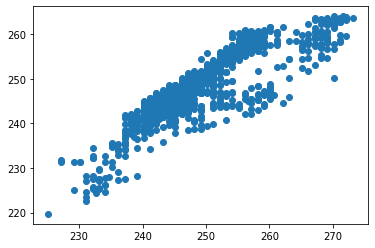

In [8]:
plt.scatter(station_vals, model_vals)

Now each station should be matched with a value grid cell value

### Normalize the model mean to match that of the station distribution
Find a factor, $\beta$ such that the model mean $$\frac{\mu_m}{\beta} \approx \mu_s$$ where $\mu_s$ is the station mean. 

In [9]:
# calculate ratios with applied correction
ratio, best_tol = scale_model_obs(model_vals, station_vals)
assert not np.any(np.isnan(ratio))
matched_df = matched_df.assign(ratio=ratio)
print(best_tol)

0.996781877025386


In [10]:
matched_df = matched_df.assign(model_vals = model_vals)
matched_df[matched_df.ratio > 3]

,ilocy,ilocx,Tmin (degC),rlat,rlon,lat,lon,station_name,ratio,model_vals


In [11]:
matched_df.head(3)

,ilocy,ilocx,Tmin (degC),rlat,rlon,lat,lon,station_name,ratio,model_vals
0,552,1011,255.15,-4.517790,10.457750,42.0333,-82.9000,HARROW CDA,0.977559,260.167236
1,552,1017,257.15,-4.547677,10.753982,41.9500,-82.5167,POINT PELEE,0.984618,260.326752
2,553,1007,258.15,-4.474659,10.302673,42.1034,-83.0945,AMHERSTBURG,0.990677,259.740845


In [12]:
df_path_write = resource_filename('climpyrical', f'/nrc_data/processed/{file_dv}_processed_station.csv')
matched_df.to_csv(df_path_write, index=False)

matched_df.to_csv(f'~/dash-dv-explorer/assets/data/stations/{file_dv}_stations.csv', index=False)

In [13]:
assert np.all(matched_df['ratio'] >= 0)

# Process NRC Locations

In [14]:
nrc_path = '/home/nannau/nrc_data/NBCC_2020_new_coords.xlsm'
df_nrc = pd.read_excel(nrc_path).dropna()

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# get rotated pole coordinates
rlon_st, rlat_st = transform_coords(df_nrc['2020 Longitude'].values, df_nrc['2020 Latitude'].values)
df_nrc = df_nrc.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

/home/nannau/tri/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
# find indices of the station locations
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df_nrc.rlon.values, 
            df_nrc.rlat.values
)
# write to new dataframe
df_nrc_matched = pd.DataFrame(
    {'ilocy': iy, 
     'ilocx': ix, 
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     'rlat':df_nrc.rlat, 
     'rlon':df_nrc.rlon, 
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
)

df_nrc_matched.to_csv('./data/processed/nrc_locations.csv', index=False)

In [16]:
df_nrc

,LocationID,SortOrder,Location,Prov,2015 Elev (m),2020 Elev (m),Was Elev. Changed,2015 Lat.,2015 Long.,2020 Latitude,2020 Longitude,Was Lat. Changed,Was Long. Changed,rlon,rlat
0,1.0,10.0,100 Mile House,BC,1040,926,Yes,51.6500,-121.2833,51.64,-121.3,Yes,Yes,-14.893575,6.472805
1,2.0,20.0,Abbotsford,BC,70,70,No,49.0517,-122.3289,49.05,-122.33,Yes,Yes,-16.329523,4.215381
2,3.0,30.0,Agassiz,BC,15,25,Yes,49.2300,-121.7700,49.24,-121.76,Yes,Yes,-15.914789,4.279140
3,4.0,40.0,Alberni,BC,12,50,Yes,49.2700,-124.8000,49.27,-124.8,No,No,-17.785699,4.957228
4,5.0,50.0,Ashcroft,BC,305,305,No,50.7200,-121.2800,50.72,-121.28,No,No,-15.163711,5.592810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,632.0,6760.0,Kugluktuk,NU,10,15,Yes,67.8300,-115.0800,67.83,-115.1,No,Yes,-7.222514,21.173542
676,637.0,6770.0,Nottingham Island,NU,30,30,No,63.1000,-78.0000,63.12,-77.93,Yes,Yes,8.872319,16.711316
677,639.0,6780.0,Resolute,NU,25,20,Yes,74.6800,-94.9000,74.70,-94.83,Yes,Yes,0.643710,27.208988
678,640.0,6790.0,Resolution Island,NU,5,0,Yes,61.3000,-64.8833,61.31,-64.87,Yes,Yes,15.487842,17.032368
